In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
F = np.array([
    [0.284, 0.883, 1.384, 1.856, 2.644],
    [-3.856, -3.953, -5.112, -7.632, -8.011]
])
n = F.shape[1]

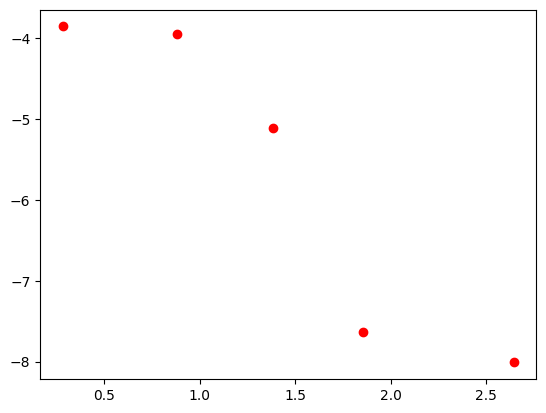

In [3]:
plt.scatter(F[0], F[1], marker='o', color='red');

### Построение интерполяционного многочлена Лагранжа. Вычисление $L_4(x_1 + x_2)$

In [4]:
import sympy
import typing as t


x, y = sympy.symbols('x, y')

In [5]:
def p(x: sympy.Symbol | float, n: int, i: int, X: np.ndarray, y: float):
    index = list(range(n+1))
    index.pop(i)
    return y * sympy.prod([(x - X[j]) / (X[i] - X[j]) for j in index])

In [6]:
L = sympy.simplify(sum([p(x, 4, i, F[0], y) for i, y in enumerate(F[1])]))

In [7]:
L

1.98692125087088*x**4 - 9.49027836376213*x**3 + 13.0311542101793*x**2 - 6.81939776960435*x - 2.76587030446744

In [8]:
float(L.subs(x, F[0][1] + F[0][2]))

-9.344467459447259

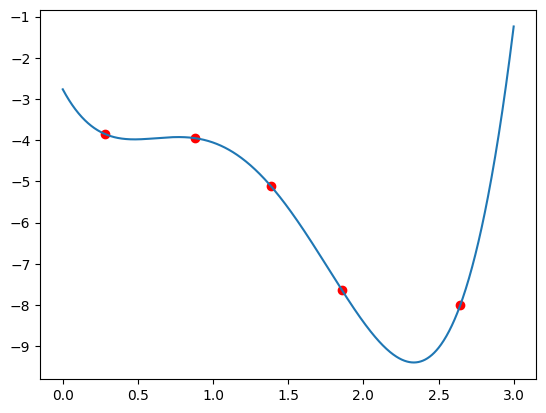

In [9]:
a = np.linspace(0, 3, 1000)
b_L = [float(L.subs(x, val)) for val in a]
plt.plot(a, b_L);
plt.scatter(F[0], F[1], color='red');

### Построение таблицы конечных и разделенных разностей

In [10]:
def finite_difference_table(Y: np.ndarray):
    res = [Y]
    n = len(Y) - 1
    while n:
        delta = np.zeros(n)
        temp = res[-1]
        for i in range(len(temp) - 1):
            delta[i] = temp[i + 1] - temp[i]
        n -= 1
        res.append(delta)
    return tuple(res)

In [11]:
finite_difference_table(F[1])

(array([-3.856, -3.953, -5.112, -7.632, -8.011]),
 array([-0.097, -1.159, -2.52 , -0.379]),
 array([-1.062, -1.361,  2.141]),
 array([-0.299,  3.502]),
 array([3.801]))

In [12]:
def divided_difference_table(X: np.ndarray, Y: np.ndarray):
    res = [Y]
    N = len(Y)
    n = N - 1
    while n:
        delta = np.zeros(n)
        temp = res[-1]
        for i in range(len(temp) - 1):
            delta[i] = (temp[i + 1] - temp[i]) / (X[i + N - n] - X[i])
        n -= 1
        res.append(delta)
    return tuple(res)

In [13]:
divided_difference_table(F[0], F[1])

(array([-3.856, -3.953, -5.112, -7.632, -8.011]),
 array([-0.16193656, -2.31337325, -5.33898305, -0.48096447]),
 array([-1.95585154, -3.10956814,  3.8555703 ]),
 array([-0.73391641,  3.95521774]),
 array([1.98692125]))

### Построение полинома Ньютона и вычисление значения $N_4(x_1+x_2)$. Построение графика многочлена Ньютона.

In [14]:
def Newton_polynomial(x: sympy.Symbol | float, X: np.ndarray, divided_difference_table: t.Tuple):
    res = []
    for difference_num, divided_difference in enumerate(divided_difference_table):
        res.append(divided_difference[0] * sympy.prod([x - X[i] for i in range(difference_num)]))
    return sum(res)

In [15]:
N = Newton_polynomial(x, F[0], divided_difference_table(F[0], F[1]))

In [16]:
N

-0.161936560934891*x + 1.98692125087088*(x - 1.856)*(x - 1.384)*(x - 0.883)*(x - 0.284) - 0.733916411174121*(x - 1.384)*(x - 0.883)*(x - 0.284) - 1.9558515386892*(x - 0.883)*(x - 0.284) - 3.81001001669449

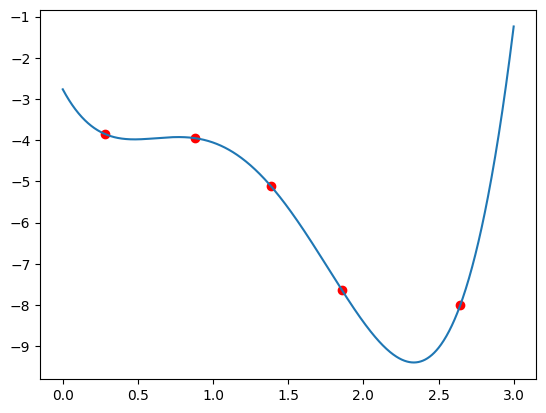

In [17]:
b_N = [float(N.subs(x, val)) for val in a]
plt.plot(a, b_N);
plt.scatter(F[0], F[1], color='red');

### Построение интерполяционных сплайнов: линейных и квадратичных. Построение графиков сплайнов.

In [18]:
linear_intervals = np.array([
    [F[0][i], F[0][i + 1]] for i in range(len(F[0]) - 1)
])

In [19]:
linear_intervals

array([[0.284, 0.883],
       [0.883, 1.384],
       [1.384, 1.856],
       [1.856, 2.644]])

In [20]:
Y = F[1]
linear_coefficients = []
for i in range(len(Y) - 1):
    x0, x1 = linear_intervals[i]
    res = np.linalg.solve(
        np.array([[x0, 1], [x1, 1]]),
        np.array([Y[i], Y[i + 1]])
    )
    linear_coefficients.append(res)

In [21]:
linear_coefficients

[array([-0.16193656, -3.81001002]),
 array([-2.31337325, -1.91029142]),
 array([-5.33898305,  2.27715254]),
 array([-0.48096447, -6.73932995])]

In [22]:
linear_spline = sympy.Piecewise(
    *[(coef[0] * x + coef[1], (x >= interval[0]) & (x < interval[1])) for interval, coef in zip(linear_intervals, linear_coefficients)]
)

In [23]:
linear_spline

Piecewise((-0.161936560934892*x - 3.81001001669449, (x >= 0.284) & (x < 0.883)), (-2.31337325349302*x - 1.91029141716567, (x >= 0.883) & (x < 1.384)), (2.27715254237288 - 5.33898305084745*x, (x >= 1.384) & (x < 1.856)), (-0.480964467005076*x - 6.73932994923858, (x >= 1.856) & (x < 2.644)))

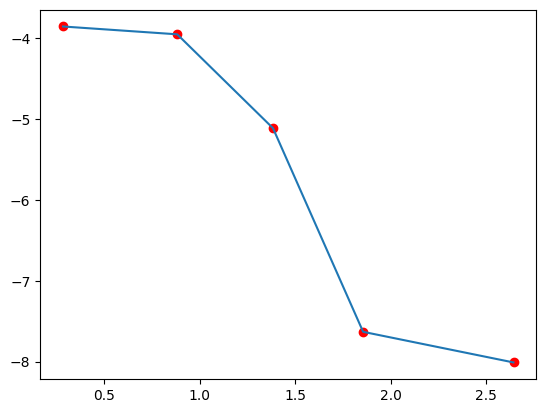

In [24]:
b_l = [float(linear_spline.subs(x, val)) for val in a]
plt.plot(a, b_l);
plt.scatter(F[0], F[1], color='red');

In [25]:
square_intervals = np.array([
    [F[0][i], F[0][i + 1], F[0][i + 2]] for i in range(0, len(F[0]) - 2, 2)
])

In [26]:
square_intervals

array([[0.284, 0.883, 1.384],
       [1.384, 1.856, 2.644]])

In [27]:
square_coefficients = []
for int_id, i in enumerate(range(0, len(Y) - 2, 2)):
    x0, x1, x2 = square_intervals[int_id]
    res = np.linalg.solve(
        np.array([[x0 ** 2, x0, 1], [x1 ** 2, x1, 1], [x2 ** 2, x2, 1]]),
        np.array([Y[i], Y[i + 1], Y[i + 2]])
    )
    square_coefficients.append(res)

In [28]:
square_coefficients

[array([-1.95585154,  2.12054218, -4.30048282]),
 array([  3.8555703 , -17.83103084,  12.18097141])]

In [29]:
square_spline = sympy.Piecewise(
    *[(coef[0] * x ** 2 + coef[1] * x + coef[2], (x >= interval[0]) & (x < interval[-1])) for interval, coef in zip(square_intervals, square_coefficients)]
)

In [30]:
square_spline

Piecewise((-1.9558515386892*x**2 + 2.12054218471541*x - 4.30048281875466, (x >= 0.284) & (x < 1.384)), (3.8555703046368*x**2 - 17.8310308378707*x + 12.1809714061747, (x >= 1.384) & (x < 2.644)))

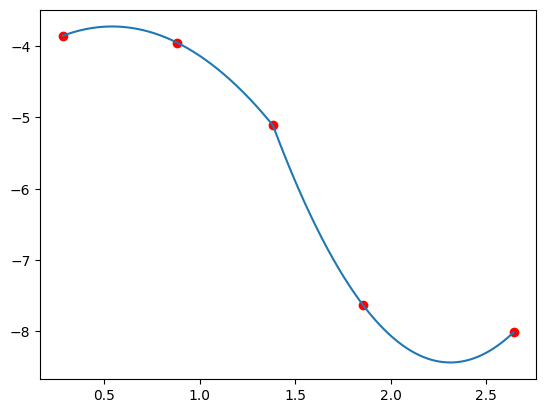

In [31]:
b_s = [float(square_spline.subs(x, val)) for val in a]
plt.plot(a, b_s);
plt.scatter(F[0], F[1], color='red');

### Построение графиков сплайнов на одном чертеже с графиком полиномов.

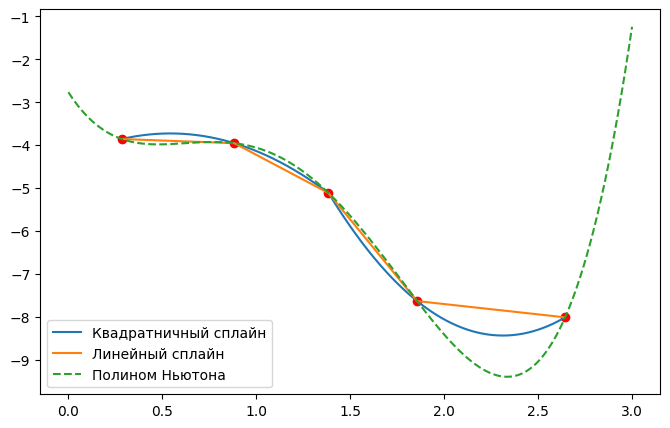

In [32]:
plt.figure(figsize=(8,5))
plt.plot(a, b_s);
plt.plot(a, b_l);
plt.plot(a, b_N, linestyle='--');
plt.legend([
    'Квадратничный сплайн',
    'Линейный сплайн',
    'Полином Ньютона',
], loc='lower left')
plt.scatter(F[0], F[1], color='red');